In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
import gradient_analyze as ga
import hp_file

In [2]:
filename = './results.pickle'

with open(filename, "rb") as file:
    results = pickle.load(file)

In [3]:
hess_exact = np.array([[ 0.794,  0.055,  0.109, -0.145,  0.   ],
       [ 0.055,  0.794, -0.042,  0.056, -0.   ],
       [ 0.109, -0.042,  0.794,  0.11 ,  0.   ],
       [-0.145,  0.056,  0.11 ,  0.794,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   , -0.   ]])

In [4]:
corr = lambda x: np.array(2 * x, dtype="float64") - np.diag(np.diag(np.array(x, dtype="float64")))

ga.calculate_new_quantity(['hess_ps'], 'hess_ps_corr', corr, results, hp_file)
ga.calculate_new_quantity(['hess_fd'], 'hess_fd_corr', corr, results, hp_file)

In [5]:
f = lambda x: np.sum((x - hess_exact) ** 2)

ga.calculate_new_quantity(['hess_ps_corr'], 'hess_ps_err', f, results, hp_file)
ga.calculate_new_quantity(['hess_fd_corr'], 'hess_fd_err', f, results, hp_file)

In [6]:
results_processed = ga.avg_quantities(['hess_ps_err', 'hess_fd_err'], results, hp_file)

In [7]:
results_processed_accessed = ga.access_quantities(['hess_ps_err', 'hess_fd_err'], results, hp_file)

In [8]:
n_shots = [10, 20, 41, 84, 119, 242, 492, 1000, 2031,
           4125, 8192, 11938, 24245, 49239, 100000]
n_shots = n_shots[7]
n_shots

1000

In [9]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

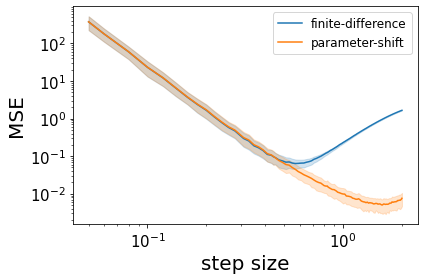

In [10]:
results_slice = ga.calculate_slice({"n_shots": n_shots}, results_processed)
results_slice_acc = ga.calculate_slice({"n_shots": n_shots}, results_processed_accessed)
x, y_fd = ga.make_numpy(results_slice, "h", "hess_fd_err")
x, y_ps = ga.make_numpy(results_slice, "h", "hess_ps_err")

stds_fd = []
stds_ps = []

for h in x:
    errors = list(ga.calculate_slice({"h": h}, results_slice_acc).values())[0]
    errors_fd = errors["hess_fd_err"]
    errors_ps = errors["hess_ps_err"]
    
    stds_fd.append(np.std(errors_fd))
    stds_ps.append(np.std(errors_ps))

stds_fd = np.array(stds_fd)
stds_ps = np.array(stds_ps)

plt.fill_between(x, y_fd - stds_fd, y_fd + stds_fd, color=cols[0], alpha=0.2)
plt.fill_between(x, y_ps - stds_ps, y_ps + stds_ps, color=cols[1], alpha=0.2)
plt.plot(x, y_fd, label="finite-difference", c=cols[0])
plt.plot(x, y_ps, label="parameter-shift", c=cols[1])
# plt.axvline(np.pi / 2, c="black", alpha=0.4, linestyle=":")
plt.xlabel('step size', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend()

# plt.savefig("tradeoff_1.pdf")
plt.yscale("log")
# plt.ylim(10**-5.25, 10**(-0.95))
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)
# plt.title("(A)", loc="left", fontsize=15)
plt.tight_layout()
plt.savefig("ps_vs_fd_hess.pdf")

In [11]:
max_point = 8
y_fit_low = np.log(y_fd[:max_point])
x_fit_low = np.log(x[:max_point])

p = np.polyfit(x_fit_low, y_fit_low, 1)
print(p[0])

y_fit_low = p[0] * np.log(x) + p[1]
y_fit_low = np.exp(y_fit_low)

-3.948615578367928


In [12]:
min_point = 40
max_point = 50
y_fit_high_ = np.log(y_fd[min_point:max_point])
x_fit_high_ = np.log(x[min_point:max_point])

ppp = np.polyfit(x_fit_high_, y_fit_high_, 1)
print(ppp[0])

y_fit_high_ = ppp[0] * np.log(x) + ppp[1]
y_fit_high_ = np.exp(y_fit_high_)

3.2889869941077534


In [13]:
min_point = 80
max_point = 99
y_fit_high = np.log(y_fd[min_point:max_point])
x_fit_high = np.log(x[min_point:max_point])

pp = np.polyfit(x_fit_high, y_fit_high, 1)
print(pp[0])

y_fit_high = pp[0] * np.log(x) + pp[1]
y_fit_high = np.exp(y_fit_high)

2.3275174603063657


/home/tom/miniconda3/envs/derivatives-of-variational-circuits/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


(0.0001, 880.9477291774014)

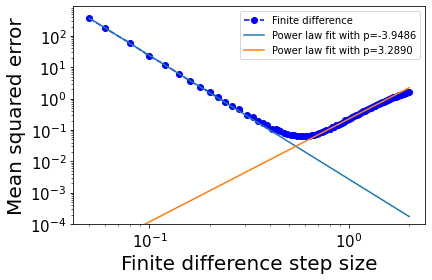

In [16]:
plt.plot(x, y_fd, '--bo', label="Finite difference")
plt.plot(x, y_fit_low, label="Power law fit with p={:.4f}".format(p[0]))
# plt.plot(x, y_fit_high, label="Power law fit with p={:.4f}".format(pp[0]))
plt.plot(x, y_fit_high_, label="Power law fit with p={:.4f}".format(ppp[0]))
plt.xlabel('Finite difference step size', fontsize=20)
plt.ylabel('Mean squared error', fontsize=20)
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend()
plt.tight_layout()
plt.savefig("tradeoff_1.pdf")
plt.yscale("log")
plt.ylim(10**-4, 0)

In [17]:
n_shots_list = [10, 20, 41, 84, 119, 242, 492, 1000, 2031,
           4125, 8192, 11938, 24245, 49239, 100000]

errs = []
err_fds = []
errs_vars = []

for n_shots in n_shots_list:
    results_slice = ga.calculate_slice({"n_shots": n_shots}, results_processed)
    results_slice_acc = ga.calculate_slice({"n_shots": n_shots}, results_processed_accessed)
    x, y_fd = ga.make_numpy(results_slice, "h", "hess_fd_err")
    x, y_ps = ga.make_numpy(results_slice, "h", "hess_ps_err")
    opt_arg = np.argmin(np.abs(x - np.pi / 2))
    opt_x = x[opt_arg]
    
    err = np.min(y_ps)
    opt_x = x[np.argmin(y_ps)]
    
    results_slice_acc_h = ga.calculate_slice({"h": opt_x}, results_slice_acc)
    results_slice_acc_h = list(results_slice_acc_h.values())[0]["hess_ps_err"]

    errs.append(err)
    
    err_fd = np.min(y_fd)
    err_fds.append(err_fd)
    
    errs_vars.append(np.std(results_slice_acc_h))

In [18]:
errs = np.array(errs)
errs_vars = np.array(errs_vars)

In [19]:
min_point = 0
max_point = -1
y_fit_high = np.log(errs[min_point:max_point])
x_fit_high = np.log(n_shots_list[min_point:max_point])

pp = np.polyfit(x_fit_high, y_fit_high, 1)
print(pp[0])

y_fit_high = pp[0] * np.log(x) + pp[1]
y_fit_high = np.exp(y_fit_high)

-1.0007730459228334


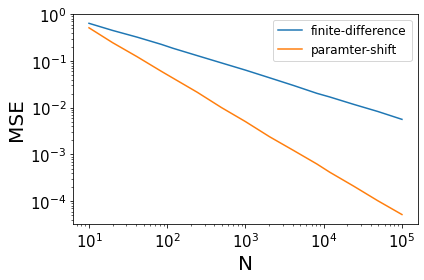

In [20]:
# plt.fill_between(n_shots_list, errs - errs_vars, errs + errs_vars, color=cols[0], alpha=0.2)
plt.plot(n_shots_list, err_fds, label="finite-difference")
plt.plot(n_shots_list, errs, label="paramter-shift")
plt.xlabel('N', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)
# plt.title("(B)", loc="left", fontsize=15)
plt.tight_layout()
plt.savefig("ps_vs_fd_N.pdf")
# # plt.ylim(10**-5.25, 10**(-0.95))

In [21]:
min_point = 0
max_point = -1
y_fit_high = np.log(errs[min_point:max_point])
x_fit_high = np.log(n_shots_list[min_point:max_point])

pp = np.polyfit(x_fit_high, y_fit_high, 1)
print(pp[0])

y_fit_high = pp[0] * np.log(x) + pp[1]
y_fit_high = np.exp(y_fit_high)

-1.0007730459228334


In [22]:
min_point = 10
max_point = -1
y_fit_high = np.log(err_fds[min_point:max_point])
x_fit_high = np.log(n_shots_list[min_point:max_point])

pp = np.polyfit(x_fit_high, y_fit_high, 1)
print(pp[0])

y_fit_high = pp[0] * np.log(x) + pp[1]
y_fit_high = np.exp(y_fit_high)

-0.5012673016787207
